In [1]:
import pandas as pd

enriched_path = "/workspaces/maxsold/data/raw_data/item_enriched_details/item_enriched_details_20251201.parquet"
items_path = "/workspaces/maxsold/data/raw_data/items_details/items_details_20251201.parquet"

# Read enriched data and only the needed columns from items details
df_enriched = pd.read_parquet(enriched_path)
df_items = pd.read_parquet(items_path, columns=["id", "current_bid"])

# Ensure merge keys have the same dtype (convert both to string)
df_enriched["item_id"] = df_enriched["item_id"].astype(str)
df_items["id"] = df_items["id"].astype(str)

# Merge: keep all columns from enriched and only current_bid from items details
merged = df_enriched.merge(df_items[["id", "current_bid"]], left_on="item_id", right_on="id", how="left")
if "id" in merged.columns:
    merged = merged.drop(columns=["id"])

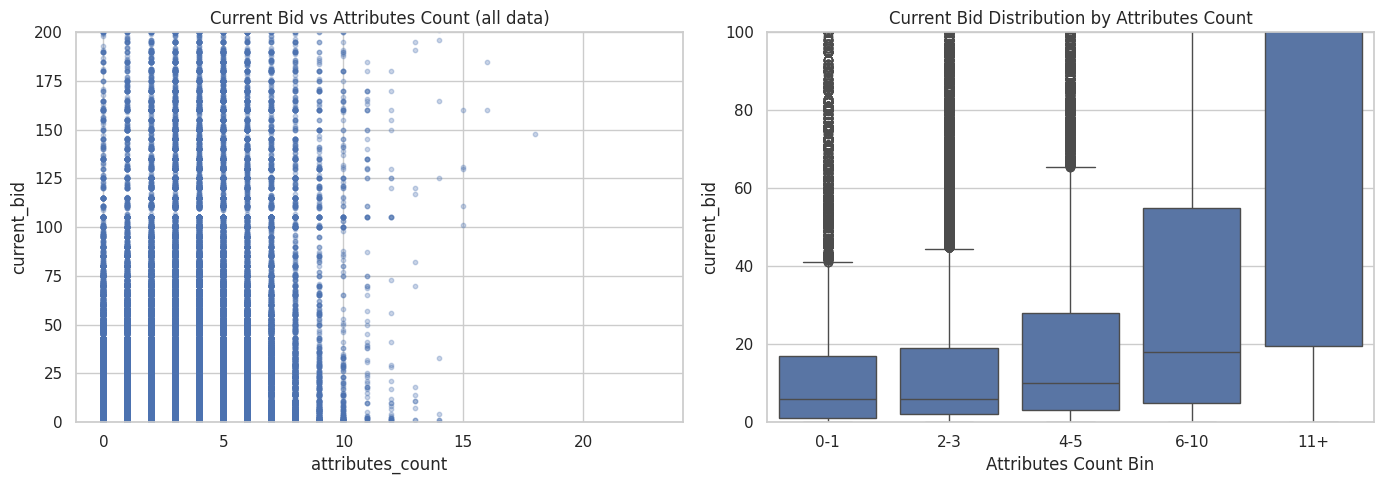

Correlation between attributes_count and current_bid: 0.1352

Summary statistics by attributes_count bins:

0-1 attributes:
  Count: 24529
  Mean bid: $18.56
  Median bid: $6.00
  Std: $71.43

2-3 attributes:
  Count: 97299
  Mean bid: $20.60
  Median bid: $6.00
  Std: $88.66

4-5 attributes:
  Count: 65174
  Mean bid: $31.50
  Median bid: $10.00
  Std: $99.94

6-10 attributes:
  Count: 18434
  Mean bid: $67.97
  Median bid: $18.00
  Std: $239.50

11+ attributes:
  Count: 228
  Mean bid: $330.25
  Median bid: $130.25
  Std: $800.87


In [4]:
# Analyze relationship between current_bid and attributes_count
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot with alpha for density visualization
axes[0].scatter(merged["attributes_count"], merged["current_bid"], alpha=0.3, s=10)
axes[0].set_xlabel("attributes_count")
axes[0].set_ylabel("current_bid")
axes[0].set_title("Current Bid vs Attributes Count (all data)")
axes[0].set_ylim(0, 200)

# Box plot by attributes_count bins
merged_with_bid = merged[merged["current_bid"] >= 0].copy()
merged_with_bid["attr_bin"] = pd.cut(merged_with_bid["attributes_count"], bins=[0, 1, 3, 5, 10, 20], labels=["0-1", "2-3", "4-5", "6-10", "11+"])
sns.boxplot(data=merged_with_bid, x="attr_bin", y="current_bid", ax=axes[1])
axes[1].set_xlabel("Attributes Count Bin")
axes[1].set_ylabel("current_bid")
axes[1].set_title("Current Bid Distribution by Attributes Count")
axes[1].set_ylim(0, 100)

plt.tight_layout()
plt.show()

# Calculate correlation
correlation = merged["attributes_count"].corr(merged["current_bid"])
print(f"Correlation between attributes_count and current_bid: {correlation:.4f}")

# Summary statistics by attributes_count bins
print("\nSummary statistics by attributes_count bins:")
for name, group in merged_with_bid.groupby("attr_bin", observed=True):
    print(f"\n{name} attributes:")
    print(f"  Count: {len(group)}")
    print(f"  Mean bid: ${group['current_bid'].mean():.2f}")
    print(f"  Median bid: ${group['current_bid'].median():.2f}")
    print(f"  Std: ${group['current_bid'].std():.2f}")

Top 15 most common attribute name-value pairs:
     attr_name attr_value  count
         color      black   4953
      material       wood   4739
      material    ceramic   4348
      material      glass   3772
      material  porcelain   3767
      material      metal   3122
      material    plastic   2729
         color      white   2580
        signed        yes   2366
frame_material       wood   1812
        framed        yes   1363
         style    vintage   1342
        format  hardcover   1332
      material    leather   1289
         metal     silver   1235


Attribute: color = black
  Count: 4953 items
  Mean bid: $23.83
  Median bid: $6.01
  Mean (non-zero): $26.76
  Median (non-zero): $9.00
  Std: $88.26
  Min: $0.00, Max: $5000.00

Attribute: material = wood
  Count: 4739 items
  Mean bid: $22.22
  Median bid: $6.00
  Mean (non-zero): $24.88
  Median (non-zero): $8.02
  Std: $59.37
  Min: $0.00, Max: $1910.00

Attribute: material = ceramic
  Count: 4348 items
  Mean bid:

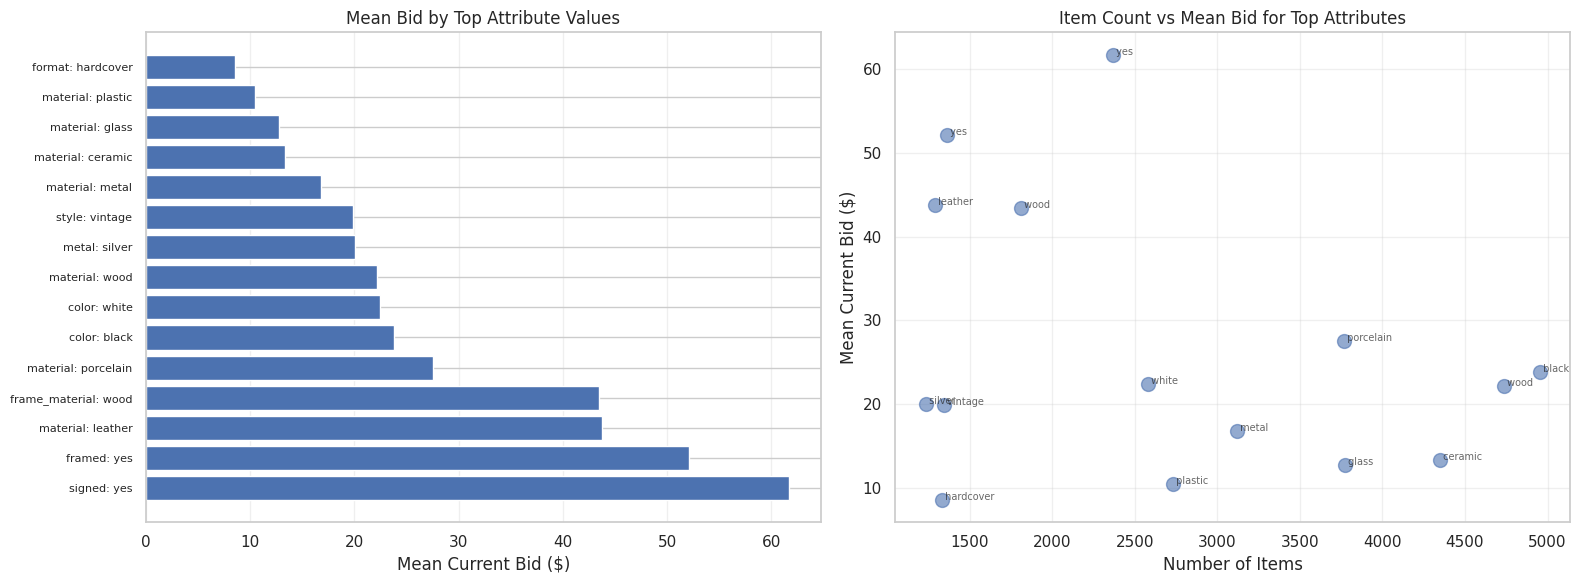

In [5]:
import numpy as np

# Analyze most common attribute values and their relationship with current_bid

# Parse all attributes and collect name-value pairs
attribute_pairs = []
for idx, row in merged.iterrows():
    if pd.isna(row["attributes"]):
        continue
    parsed = row["attributes"]
    if isinstance(parsed, str):
        try:
            parsed = json.loads(parsed)
        except Exception:
            try:
                parsed = ast.literal_eval(parsed)
            except Exception:
                continue
    if not isinstance(parsed, list):
        continue
    for entry in parsed:
        if not isinstance(entry, dict):
            continue
        name = (entry.get("name") or entry.get("title") or "").lower().strip()
        value = entry.get("value") or entry.get("values") or entry.get("text")
        if name and value:
            # Convert value to string and clean it
            value_str = str(value).lower().strip()
            if value_str and value_str != "none" and len(value_str) < 100:  # Skip very long values
                attribute_pairs.append({
                    "item_id": row["item_id"],
                    "attr_name": name,
                    "attr_value": value_str,
                    "current_bid": row["current_bid"]
                })

df_attrs = pd.DataFrame(attribute_pairs)

# Find top 15 most common attribute name-value pairs
top_pairs = df_attrs.groupby(["attr_name", "attr_value"]).size().nlargest(15).reset_index(name="count")

print("Top 15 most common attribute name-value pairs:")
print(top_pairs.to_string(index=False))
print("\n" + "="*80 + "\n")

# For each top pair, show bid statistics
for _, row in top_pairs.iterrows():
    attr_name = row["attr_name"]
    attr_value = row["attr_value"]
    count = row["count"]
    
    # Get bids for items with this attribute
    mask = (df_attrs["attr_name"] == attr_name) & (df_attrs["attr_value"] == attr_value)
    bids = df_attrs[mask]["current_bid"]
    bids_nonzero = bids[bids > 0]
    
    print(f"Attribute: {attr_name} = {attr_value}")
    print(f"  Count: {count} items")
    print(f"  Mean bid: ${bids.mean():.2f}")
    print(f"  Median bid: ${bids.median():.2f}")
    if len(bids_nonzero) > 0:
        print(f"  Mean (non-zero): ${bids_nonzero.mean():.2f}")
        print(f"  Median (non-zero): ${bids_nonzero.median():.2f}")
    print(f"  Std: ${bids.std():.2f}")
    print(f"  Min: ${bids.min():.2f}, Max: ${bids.max():.2f}")
    print()

# Visualize top attribute values by average bid
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Create data for visualization
vis_data = []
for _, row in top_pairs.iterrows():
    mask = (df_attrs["attr_name"] == row["attr_name"]) & (df_attrs["attr_value"] == row["attr_value"])
    bids = df_attrs[mask]["current_bid"]
    bids_nonzero = bids[bids > 0]
    
    vis_data.append({
        "label": f"{row['attr_name']}: {row['attr_value'][:30]}",
        "mean_bid": bids.mean(),
        "median_bid": bids.median(),
        "count": row["count"],
        "mean_nonzero": bids_nonzero.mean() if len(bids_nonzero) > 0 else 0
    })

vis_df = pd.DataFrame(vis_data).sort_values("mean_bid", ascending=False)

# Bar plot of mean bids
axes[0].barh(range(len(vis_df)), vis_df["mean_bid"])
axes[0].set_yticks(range(len(vis_df)))
axes[0].set_yticklabels(vis_df["label"], fontsize=8)
axes[0].set_xlabel("Mean Current Bid ($)")
axes[0].set_title("Mean Bid by Top Attribute Values")
axes[0].grid(axis='x', alpha=0.3)

# Scatter: count vs mean bid
axes[1].scatter(vis_df["count"], vis_df["mean_bid"], s=100, alpha=0.6)
axes[1].set_xlabel("Number of Items")
axes[1].set_ylabel("Mean Current Bid ($)")
axes[1].set_title("Item Count vs Mean Bid for Top Attributes")
axes[1].grid(alpha=0.3)

# Add labels to points
for _, row in vis_df.iterrows():
    axes[1].annotate(row["label"].split(":")[1][:15], 
                     (row["count"], row["mean_bid"]), 
                     fontsize=7, alpha=0.7)

plt.tight_layout()
plt.show()

Top 15 most common categories:
category
collectibles    27389
home decor      19871
furniture       17013
art             12936
decor           11399
kitchenware     10709
books            9006
jewellery        8973
glassware        8526
jewelry          7860
lighting         6802
electronics      6568
toys             5756
clothing         5679
tools            5207


Category: collectibles
  Count: 27389 items
  Mean bid: $19.78
  Median bid: $7.00
  Mean (non-zero): $21.21
  Median (non-zero): $8.00
  Std: $62.27
  Min: $0.00, Max: $3569.00

Category: home decor
  Count: 19871 items
  Mean bid: $23.41
  Median bid: $6.00
  Mean (non-zero): $25.66
  Median (non-zero): $8.00
  Std: $77.17
  Min: $0.00, Max: $5150.00

Category: furniture
  Count: 17013 items
  Mean bid: $52.36
  Median bid: $11.00
  Mean (non-zero): $59.99
  Median (non-zero): $17.00
  Std: $213.35
  Min: $0.00, Max: $13350.00

Category: art
  Count: 12936 items
  Mean bid: $42.57
  Median bid: $11.00
  Mean (non-zero)

/tmp/ipykernel_27827/2034748962.py:102: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=45, ha='right', fontsize=9)


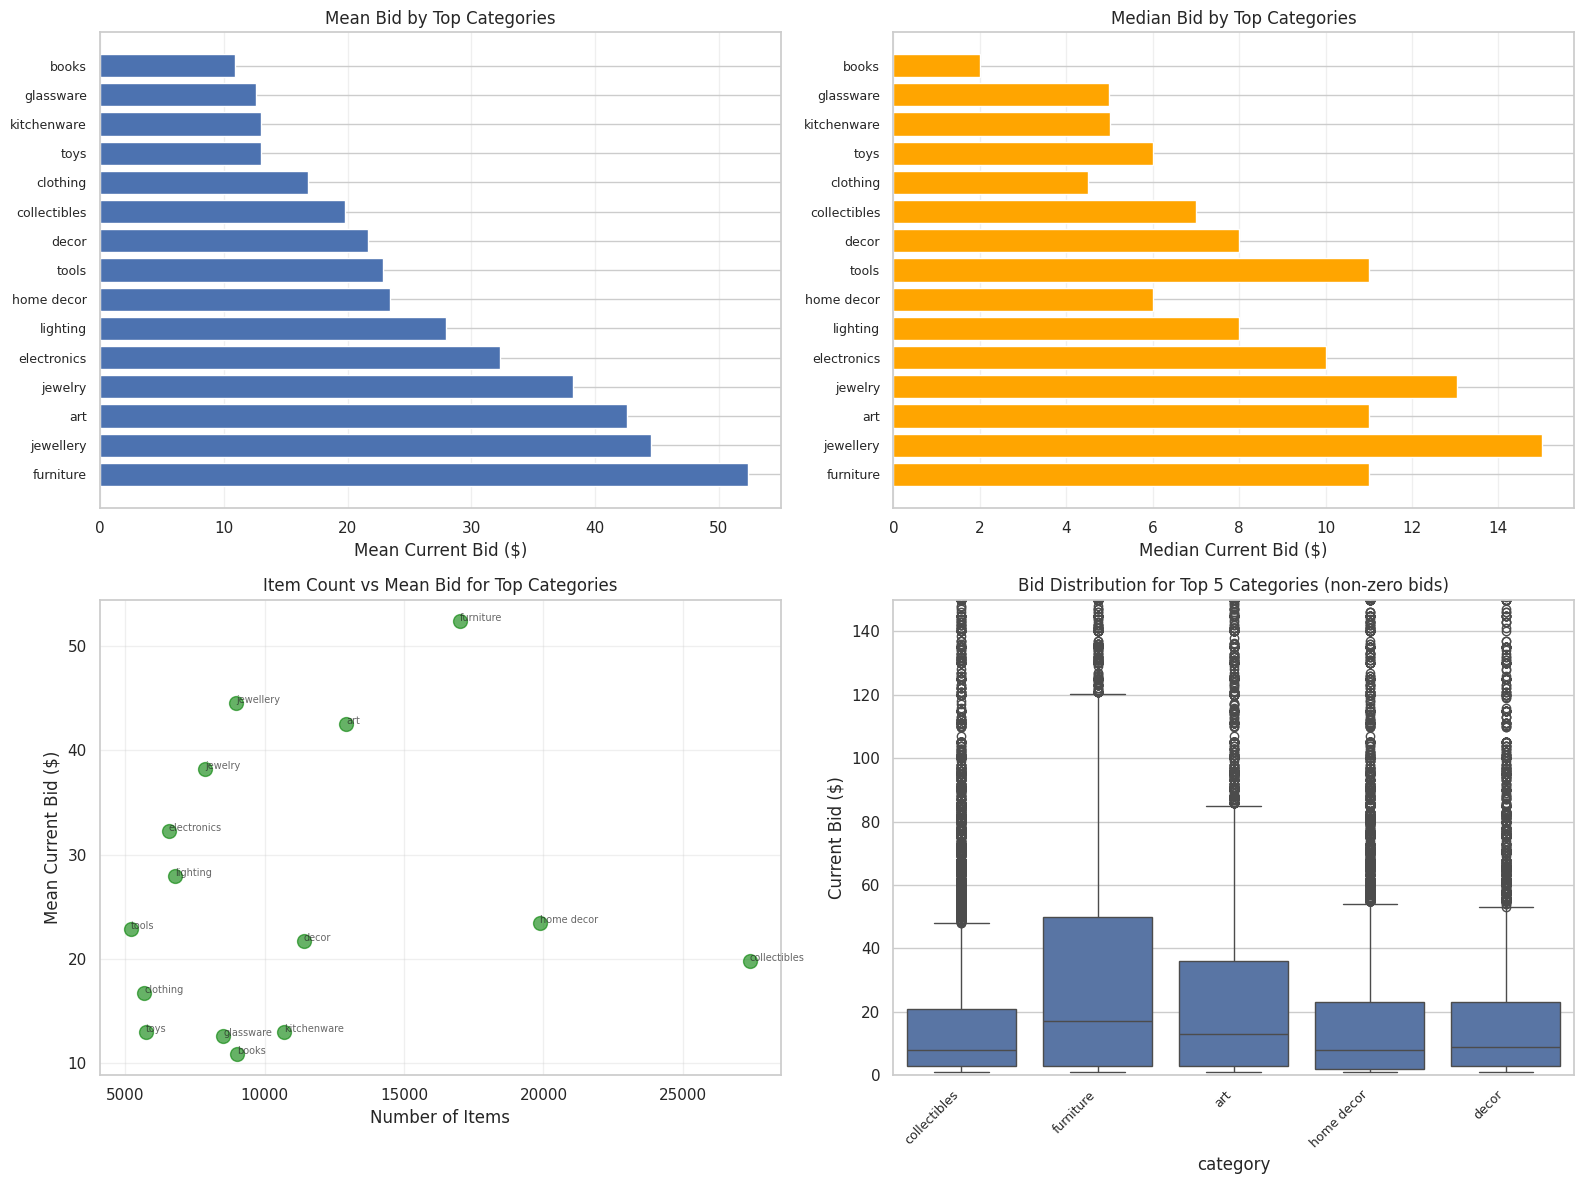

In [6]:
# Analyze most common categories vs current_bid

# Parse categories and collect category-bid pairs
category_pairs = []
for idx, row in merged.iterrows():
    if pd.isna(row["categories"]):
        continue
    parsed = row["categories"]
    if isinstance(parsed, str):
        try:
            parsed = json.loads(parsed)
        except Exception:
            try:
                parsed = ast.literal_eval(parsed)
            except Exception:
                continue
    if not isinstance(parsed, list):
        continue
    for cat in parsed:
        cat_clean = str(cat).lower().strip()
        if cat_clean and len(cat_clean) < 100:
            category_pairs.append({
                "item_id": row["item_id"],
                "category": cat_clean,
                "current_bid": row["current_bid"]
            })

df_cats = pd.DataFrame(category_pairs)

# Find top 15 most common categories
top_categories = df_cats["category"].value_counts().nlargest(15)

print("Top 15 most common categories:")
print(top_categories.to_string())
print("\n" + "="*80 + "\n")

# For each top category, show bid statistics
cat_stats = []
for cat in top_categories.index:
    bids = df_cats[df_cats["category"] == cat]["current_bid"]
    bids_nonzero = bids[bids > 0]
    
    cat_stats.append({
        "category": cat,
        "count": len(bids),
        "mean_bid": bids.mean(),
        "median_bid": bids.median(),
        "mean_nonzero": bids_nonzero.mean() if len(bids_nonzero) > 0 else 0,
        "median_nonzero": bids_nonzero.median() if len(bids_nonzero) > 0 else 0,
        "std": bids.std(),
        "min": bids.min(),
        "max": bids.max()
    })
    
    print(f"Category: {cat}")
    print(f"  Count: {len(bids)} items")
    print(f"  Mean bid: ${bids.mean():.2f}")
    print(f"  Median bid: ${bids.median():.2f}")
    if len(bids_nonzero) > 0:
        print(f"  Mean (non-zero): ${bids_nonzero.mean():.2f}")
        print(f"  Median (non-zero): ${bids_nonzero.median():.2f}")
    print(f"  Std: ${bids.std():.2f}")
    print(f"  Min: ${bids.min():.2f}, Max: ${bids.max():.2f}")
    print()

# Visualize categories by average bid
cat_stats_df = pd.DataFrame(cat_stats).sort_values("mean_bid", ascending=False)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Bar plot of mean bids
axes[0, 0].barh(range(len(cat_stats_df)), cat_stats_df["mean_bid"])
axes[0, 0].set_yticks(range(len(cat_stats_df)))
axes[0, 0].set_yticklabels(cat_stats_df["category"], fontsize=9)
axes[0, 0].set_xlabel("Mean Current Bid ($)")
axes[0, 0].set_title("Mean Bid by Top Categories")
axes[0, 0].grid(axis='x', alpha=0.3)

# Bar plot of median bids
axes[0, 1].barh(range(len(cat_stats_df)), cat_stats_df["median_bid"], color='orange')
axes[0, 1].set_yticks(range(len(cat_stats_df)))
axes[0, 1].set_yticklabels(cat_stats_df["category"], fontsize=9)
axes[0, 1].set_xlabel("Median Current Bid ($)")
axes[0, 1].set_title("Median Bid by Top Categories")
axes[0, 1].grid(axis='x', alpha=0.3)

# Scatter: count vs mean bid
axes[1, 0].scatter(cat_stats_df["count"], cat_stats_df["mean_bid"], s=100, alpha=0.6, c='green')
axes[1, 0].set_xlabel("Number of Items")
axes[1, 0].set_ylabel("Mean Current Bid ($)")
axes[1, 0].set_title("Item Count vs Mean Bid for Top Categories")
axes[1, 0].grid(alpha=0.3)
for _, row in cat_stats_df.iterrows():
    axes[1, 0].annotate(row["category"][:20], 
                        (row["count"], row["mean_bid"]), 
                        fontsize=7, alpha=0.7)

# Box plot for selected top categories
top_5_cats = top_categories.head(5).index.tolist()
cat_plot_data = df_cats[df_cats["category"].isin(top_5_cats) & (df_cats["current_bid"] > 0)].copy()
sns.boxplot(data=cat_plot_data, x="category", y="current_bid", ax=axes[1, 1])
axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=45, ha='right', fontsize=9)
axes[1, 1].set_ylabel("Current Bid ($)")
axes[1, 1].set_title("Bid Distribution for Top 5 Categories (non-zero bids)")
axes[1, 1].set_ylim(0, 150)

plt.tight_layout()
plt.show()

items_count statistics:
count    229124.0
mean     2.837058
std      3.055796
min           0.0
25%           1.0
50%           1.0
75%           4.0
max          67.0
Name: items_count, dtype: Float64

Current bid statistics:
count    229124.000000
mean         26.836169
std         111.311859
min           0.000000
25%           2.000000
50%           7.000000
75%          23.000000
max       14000.000000
Name: current_bid, dtype: float64

Valid data points: 229,124


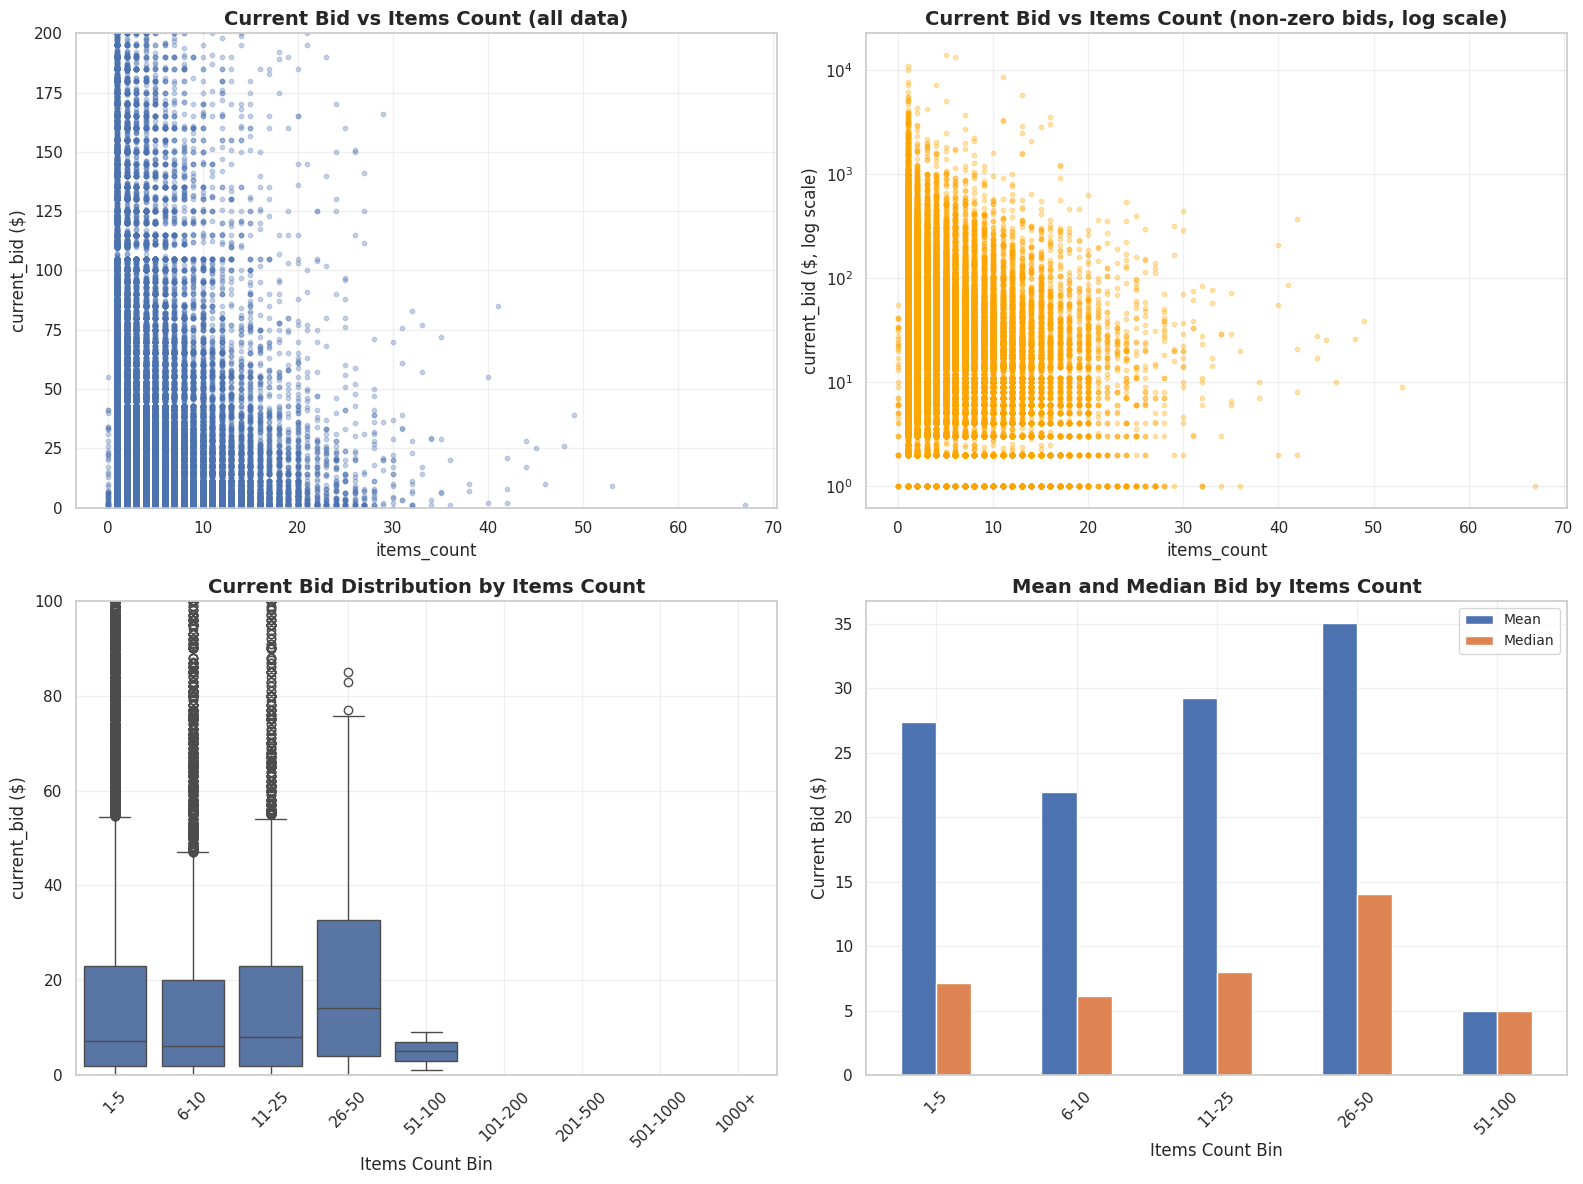


Correlation between items_count and current_bid: -0.0155

Summary statistics by items_count bins:

1-5 items:
  Count: 196,668
  Mean bid: $27.38
  Median bid: $7.16
  Std: $109.00
  Min: $0.00
  Max: $14000.00
  Non-zero bids: 180,108 (91.6%)
  Mean (non-zero): $29.89
  Median (non-zero): $9.00

6-10 items:
  Count: 25,207
  Mean bid: $21.93
  Median bid: $6.15
  Std: $108.66
  Min: $0.00
  Max: $13350.00
  Non-zero bids: 23,352 (92.6%)
  Mean (non-zero): $23.67
  Median (non-zero): $8.00

11-25 items:
  Count: 7,033
  Mean bid: $29.26
  Median bid: $8.00
  Std: $169.95
  Min: $0.00
  Max: $8600.00
  Non-zero bids: 6,634 (94.3%)
  Mean (non-zero): $31.01
  Median (non-zero): $9.00

26-50 items:
  Count: 158
  Mean bid: $35.03
  Median bid: $14.05
  Std: $66.40
  Min: $0.00
  Max: $438.00
  Non-zero bids: 154 (97.5%)
  Mean (non-zero): $35.94
  Median (non-zero): $14.18

51-100 items:
  Count: 2
  Mean bid: $5.00
  Median bid: $5.00
  Std: $5.66
  Min: $1.00
  Max: $9.00
  Non-zero bi

In [8]:
# Analyze relationship between items_count and current_bid

# Check if items_count exists
if 'items_count' not in merged.columns:
    print("Column 'items_count' not found in merged dataframe.")
    print(f"Available columns: {merged.columns.tolist()}")
else:
    print(f"items_count statistics:")
    print(merged['items_count'].describe())
    print(f"\nCurrent bid statistics:")
    print(merged['current_bid'].describe())
    
    # Filter to valid data
    valid_data = merged[(merged['items_count'].notna()) & (merged['current_bid'].notna())].copy()
    print(f"\nValid data points: {len(valid_data):,}")
    
    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Scatter plot: items_count vs current_bid
    axes[0, 0].scatter(valid_data['items_count'], valid_data['current_bid'], alpha=0.3, s=10)
    axes[0, 0].set_xlabel('items_count', fontsize=12)
    axes[0, 0].set_ylabel('current_bid ($)', fontsize=12)
    axes[0, 0].set_title('Current Bid vs Items Count (all data)', fontsize=14, fontweight='bold')
    axes[0, 0].set_ylim(0, 200)
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Scatter plot (log scale for better visibility)
    non_zero = valid_data[valid_data['current_bid'] > 0].copy()
    axes[0, 1].scatter(non_zero['items_count'], non_zero['current_bid'], alpha=0.3, s=10, color='orange')
    axes[0, 1].set_xlabel('items_count', fontsize=12)
    axes[0, 1].set_ylabel('current_bid ($, log scale)', fontsize=12)
    axes[0, 1].set_title('Current Bid vs Items Count (non-zero bids, log scale)', fontsize=14, fontweight='bold')
    axes[0, 1].set_yscale('log')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Box plot by items_count bins
    valid_data['items_bin'] = pd.cut(valid_data['items_count'], 
                                      bins=[0, 5, 10, 25, 50, 100, 200, 500, 1000, 5000], 
                                      labels=['1-5', '6-10', '11-25', '26-50', '51-100', '101-200', '201-500', '501-1000', '1000+'])
    sns.boxplot(data=valid_data, x='items_bin', y='current_bid', ax=axes[1, 0])
    axes[1, 0].set_xlabel('Items Count Bin', fontsize=12)
    axes[1, 0].set_ylabel('current_bid ($)', fontsize=12)
    axes[1, 0].set_title('Current Bid Distribution by Items Count', fontsize=14, fontweight='bold')
    axes[1, 0].set_ylim(0, 100)
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Mean bid by items_count bin
    bin_stats = valid_data.groupby('items_bin', observed=True)['current_bid'].agg(['mean', 'median', 'count'])
    bin_stats.plot(kind='bar', y=['mean', 'median'], ax=axes[1, 1])
    axes[1, 1].set_xlabel('Items Count Bin', fontsize=12)
    axes[1, 1].set_ylabel('Current Bid ($)', fontsize=12)
    axes[1, 1].set_title('Mean and Median Bid by Items Count', fontsize=14, fontweight='bold')
    axes[1, 1].legend(['Mean', 'Median'], fontsize=10)
    axes[1, 1].tick_params(axis='x', rotation=45)
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate correlation
    correlation = valid_data['items_count'].corr(valid_data['current_bid'])
    print(f"\n{'='*80}")
    print(f"Correlation between items_count and current_bid: {correlation:.4f}")
    print(f"{'='*80}")
    
    # Summary statistics by items_count bins
    print("\nSummary statistics by items_count bins:")
    print("="*80)
    for name, group in valid_data.groupby('items_bin', observed=True):
        print(f"\n{name} items:")
        print(f"  Count: {len(group):,}")
        print(f"  Mean bid: ${group['current_bid'].mean():.2f}")
        print(f"  Median bid: ${group['current_bid'].median():.2f}")
        print(f"  Std: ${group['current_bid'].std():.2f}")
        print(f"  Min: ${group['current_bid'].min():.2f}")
        print(f"  Max: ${group['current_bid'].max():.2f}")
        
        # Non-zero statistics
        non_zero_group = group[group['current_bid'] > 0]
        if len(non_zero_group) > 0:
            print(f"  Non-zero bids: {len(non_zero_group):,} ({100*len(non_zero_group)/len(group):.1f}%)")
            print(f"  Mean (non-zero): ${non_zero_group['current_bid'].mean():.2f}")
            print(f"  Median (non-zero): ${non_zero_group['current_bid'].median():.2f}")
    
    # Look at items with high items_count
    print("\n" + "="*80)
    print("Items with highest items_count:")
    print("="*80)
    top_items = valid_data.nlargest(10, 'items_count')[['item_id', 'items_count', 'current_bid']]
    for idx, row in top_items.iterrows():
        print(f"Item {row['item_id']}: {row['items_count']:.0f} items, current bid: ${row['current_bid']:.2f}")